# Model for predicting Second Language Adquisiton

We start by loading the necessary libraries.

In [1]:
from fastai.data.all import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import accuracy, F1Score
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import AutoModelForSequenceClassification
import pandas as pd
from blurr.text.data.core import *
from blurr.text.modeling.core import *
from blurr.text.utils import NLP as BLURR # lo importamos así para que sea compatible con el resto
from datasets import load_dataset, concatenate_datasets

/home/jonathan/.virtualenvs/huggingface/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Now, we load the train and validation sets.

In [2]:
import torch
torch.cuda.set_device(1)

In [3]:
train_df = pd.read_csv('train_train_set.csv',delimiter='\t')

FileNotFoundError: [Errno 2] No such file or directory: 'train_train_set.csv'

In [2]:
valid_df = pd.read_csv('validation_train_set.csv',delimiter='\t')

FileNotFoundError: [Errno 2] No such file or directory: 'validation_train_set.csv'

In [5]:
train_df['is_valid']=False

In [6]:
valid_df['is_valid']=True

In [7]:
train_valid_df = pd.concat([train_df,valid_df])

We define the indexes for training and validation.

In [8]:
train_idxs, valid_idxs = L(range(len(train_df))), L(range(len(train_df), len(train_df) + len(valid_df)))

Now, we can define the model. In this case, we use a predefined model called Roberta.

In [21]:
dl_kwargs = {"bs": 96, "val_bs": 64}
learn_kwargs = {"metrics": [accuracy]}

In [10]:
learn = BlearnerForSequenceClassification.from_data(
    train_valid_df,
    "dccuchile/bert-base-spanish-wwm-uncased",
    text_attr="Sentence",
    label_attr="Level",
    dblock_splitter=IndexSplitter(valid_idxs),
    dl_kwargs=dl_kwargs,
    learner_kwargs=learn_kwargs,
)

In [11]:
learn = learn.to_fp16()

In [12]:
learn.dls.show_batch(dataloaders=learn.dls, trunc_at=500, max_n=5)

,text,target
0,"aquí es mi número de teléfono + : + 18270918681 +. + por _ favor teléfono + : + 18270918681 +. + por _ favor teléfono + : + 18270918681 +. + por _ favor teléfono + : + 18270918681 +. + por _ favor teléfono + : + 18270918681 +. + por _ favor, puede llamar me por eso.",B1
1,"[... ] el + norte el + norte de marruecos que se llama tangier, en este ciudad conocimos a personas simpaticos y amables y serviables. visitimos a muchos monumentos historicos por _ ejemplo la grotta _ de _ hercule... etc tambien la compra... y tambien aprobechamos mucho las [... ]",A2
2,"podrias ponerte _ en _ contacto con yo en mi dirección eletrónica - mariadantas @ gmail. com, mi ( 55 ) 5133362343 o mi movil ( 55 ) 5199860032 y también mi dirección calle _ mostardeiro _ 780, piso 4, apartamento 401 [... ]",B1
3,"[... ] marruecos que se llama tangier, en este ciudad conocimos a personas simpaticos y amables y serviables. visitimos a muchos monumentos historicos por _ ejemplo la grotta _ de _ hercule... etc tambien la compra... y tambien aprobechamos mucho las discotecas porque estan [... ]",A2
4,[... ] y sobre _ todo podemos captar y ganar vocabolario argentino + viendo argentino + viendo estas peliculas en resume el director nos mostro la pura realidad de el escando lo que sucede en argentina a el año fallecen mas de ocho _ mil personas y mas de ciento _ viente _ mil que resultan [... ],C1


In [13]:
learn.fine_tune(10,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.622825,0.543471,0.797106,06:38


epoch,train_loss,valid_loss,accuracy,time
0,0.210150,0.119405,0.956308,10:37
1,0.057011,0.067367,0.971565,10:43
2,0.071489,0.047870,0.981531,10:49
3,0.048166,0.038783,0.985032,10:49
4,0.048292,0.035647,0.985782,10:50
5,0.044484,0.030195,0.988437,10:55
6,0.017480,0.027444,0.989322,10:48
7,0.008736,0.028183,0.989803,10:51
8,0.026061,0.028211,0.990053,10:50
9,0.015349,0.028582,0.990053,10:51


In [14]:
learn.export('bert')

In [15]:
learnTest = load_learner('bert')

In [16]:
learn.save('bert')

Path('models/bert.pth')

In [17]:
test_df = pd.read_csv('test_set.csv',delimiter='\t')

In [18]:
test_df['is_valid']=True

In [19]:
train_test_df = pd.concat([train_df,test_df])

In [20]:
train_idxs, test_idxs = L(range(len(train_df))), L(range(len(train_df), len(train_df) + len(test_df)))

In [23]:
learnTest = BlearnerForSequenceClassification.from_data(
    train_test_df,
    "dccuchile/bert-base-spanish-wwm-uncased",
    text_attr="Sentence",
    label_attr="Level",
    dblock_splitter=IndexSplitter(test_idxs),
    dl_kwargs=dl_kwargs,
    learner_kwargs=learn_kwargs,
)

In [24]:
learn.load('bert')

In [25]:
learn.validate()

(#2) [0.028581790626049042,0.9900534749031067]

In [26]:
preds,gt=learnTest.get_preds()

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [29]:
cm = confusion_matrix(gt, np.argmax(preds,axis=1))

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=learn.dls.vocab)

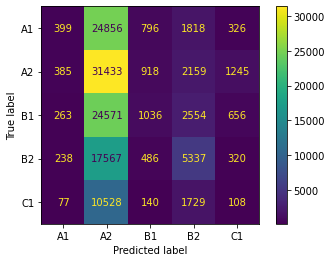

In [31]:
disp.plot()